# State of Charge Estimation with EKF
This notebook demonstrates the use of the extended Kalman filter (EKF) for state of charge (SOC) estimation. The EKF is a nonlinear state estimator that can be used to estimate the SOC of a battery. 

## Theory

### Thevenin Model
The EKF works by linearizing the nonlinear system model, which in this case, is isothermal Thevenin model defined by the following equation. For simplicity, equations for a single RC pair are shown.

$$\begin{aligned}
\left[\begin{array}{c}
\mathrm{SOC}_{k+1} \\
V_{\mathrm{rc}_{1}, k+1}
\end{array}\right] &=\left[\begin{array}{cc}
1 & 0 \\
0 & exp\left(-\frac{\Delta t}{R_{1} C_{1}}\right)
\end{array}\right]\left[\begin{array}{c}
\mathrm{SOC}_{k} \\
V_{\mathrm{rc}_{1}, k}
\end{array}\right]+\left[\begin{array}{c}
\frac{\Delta t}{Q} \\
0
\end{array}\right] I_{k} \\
V_{\mathrm{cell}, k} &=\mathrm{OCV}\left(\mathrm{SOC}_{k}\right)-R_{1} I_{k}-V_{\mathrm{rc}_{1}, k}
\end{aligned}$$

where $\mathrm{SOC}$ is the state of charge, $Q$ is the capacity, $I$ is the current, $V_{\mathrm{cell}}$ is the cell voltage, $V_{\mathrm{rc}_{1}}$ is the voltage across the resistor-capacitor pair, $C_{1}$ is the capacitance, and $R_{1}$ is the resistance. 

### Extended Kalman Filter
The EKF linearizes the system model by using the first-order Taylor series expansion of the nonlinear system model about the current state estimate $\mathbf{x}_{k}$ and the current measurement $\mathbf{z}_{k}$. As a result, EKF is a recursive estimator that uses the current state estimate $\mathbf{x}_{k}$ and the current measurement $\mathbf{z}_{k}$ to compute the next state estimate $\mathbf{x}_{k+1}$. 

The EKF is a two-step process: prediction and update. The prediction step uses the state transition matrix $\mathbf{F}_{k}$ to propagate the state estimate forward in time. The update step uses the measurement matrix $\mathbf{H}_{k}$ to update the state estimate based on the measurement. The EKF is an optimal estimator in the sense that it minimizes the mean squared error between the true state and the estimated state. The EKF is defined by the following equations:

Prediction step:
$$\begin{aligned}
\mathbf{x}_{k} &= \mathbf{F}_{k} \mathbf{x}_{k-1} + \mathbf{B}_{k} \mathbf{u}_{k} \\
\mathbf{P}_{k} &= \mathbf{F}_{k} \mathbf{P}_{k-1} \mathbf{F}_{k}^{T} + \mathbf{Q}_{k}
\end{aligned}$$

Update step:
$$\begin{aligned}
\mathbf{K}_{k} &=\mathbf{P}_{k} \mathbf{H}_{k}^{T}\left(\mathbf{H}_{k} \mathbf{P}_{k} \mathbf{H}_{k}^{T}+\mathbf{R}_{k}\right)^{-1} \\
\mathbf{x}_{k} &=\mathbf{x}_{k}+\mathbf{K}_{k}\left(\mathbf{z}_{k}-\mathbf{h}\left(\mathbf{x}_{k}\right)\right) \\
\mathbf{P}_{k} &=\left(\mathbf{I}-\mathbf{K}_{k} \mathbf{H}_{k}\right) \mathbf{P}_{k}
\end{aligned}$$

where $\mathbf{x}_{k}$ is the state vector, $\mathbf{u}_{k}$ is the input vector, $\mathbf{z}_{k}$ is the measurement vector, $\mathbf{F}_{k}$ is the state transition matrix, $\mathbf{h}$ is the measurement function, $\mathbf{H}_{k}=\frac{\partial \mathbf{h}}{\partial \mathbf{x}}\left(\mathbf{x}_{k}\right)$ is the measurement Jacobian matrix, $\mathbf{P}_{k}$ is the covariance matrix, $\mathbf{Q}_{k}$ is the process noise covariance matrix, and $\mathbf{R}_{k}$ is the measurement noise covariance matrix. For an isothermal Thevenin model, the EKF is defined by the following equations:


<div align="center">

| Variable                                       | Equation                                                                                                                    |
|------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------|
| State Vector ($\mathbf{x}_{k}$)                | $\begin{bmatrix} \mathrm{SOC}_{k} & V_{\mathrm{rc}_{1} , k} \end{bmatrix}^T$                                                |
| Input Vector ($\mathbf{u}_{k}$)                | $I_{k}$                                                                                                                     |
| Measurement Vector ($\mathbf{z}_{k}$)          | $V_{\mathrm{cell}, k}$                                                                                                      |
| State Transition Matrix ($\mathbf{F}_{k}$)     | $\begin{bmatrix} 1 & 0 \\ 0 & \exp\left(-\frac{\Delta t}{R_{1} C_{1}}\right) \end{bmatrix}$                                 |
| Input Matrix ($\mathbf{B}_{k}$)                | $\begin{bmatrix} \frac{\Delta t}{Q} & 0 \end{bmatrix}^T$                                                                    |
| Measurement Function ($\mathbf{h}$)            | $\mathrm{OCV}\left(\mathrm{SOC}_{k}\right)-R_{1} I_{k}-V_{\mathrm{rc}_{1}, k}$                                              |
| Measurement Jacobian Matrix ($\mathbf{H}_{k}$) | $\begin{bmatrix} \frac{\partial \mathrm{OCV}\left(\mathrm{SOC}_{k}\right)}{\partial \mathrm{SOC}_{k}} & -1 \end{bmatrix}^T$ |

</div>

In [1]:
import numpy as np

import sox.plant.protocol as protocol
from sox.system import IsothermalThevenin
from sox.plant import Thevenin, default_thevenin_inputs
from sox.sensor import Sensor
from sox.filter import ExtendedKalmanFilter
from sox.utils import quick_plot

## Synthetic Data
We use Thevenin model with thermal effects to generate synthetic data. The Thevenin model is a simple equivalent circuit model that can be used to simulate the behavior of a battery, as described above. 

Note that the model used here has 1-RC pair with current and temperature dependent circuit parameters. However, as we shall see later on, thh EKF uses an iso-thermal 1-RC Thevenin model with constant circuit parameters.

We then use `solve` method to simulate a `dst_schedule` protocol and then use utility function `quick_plot` to plot the synthetic data.

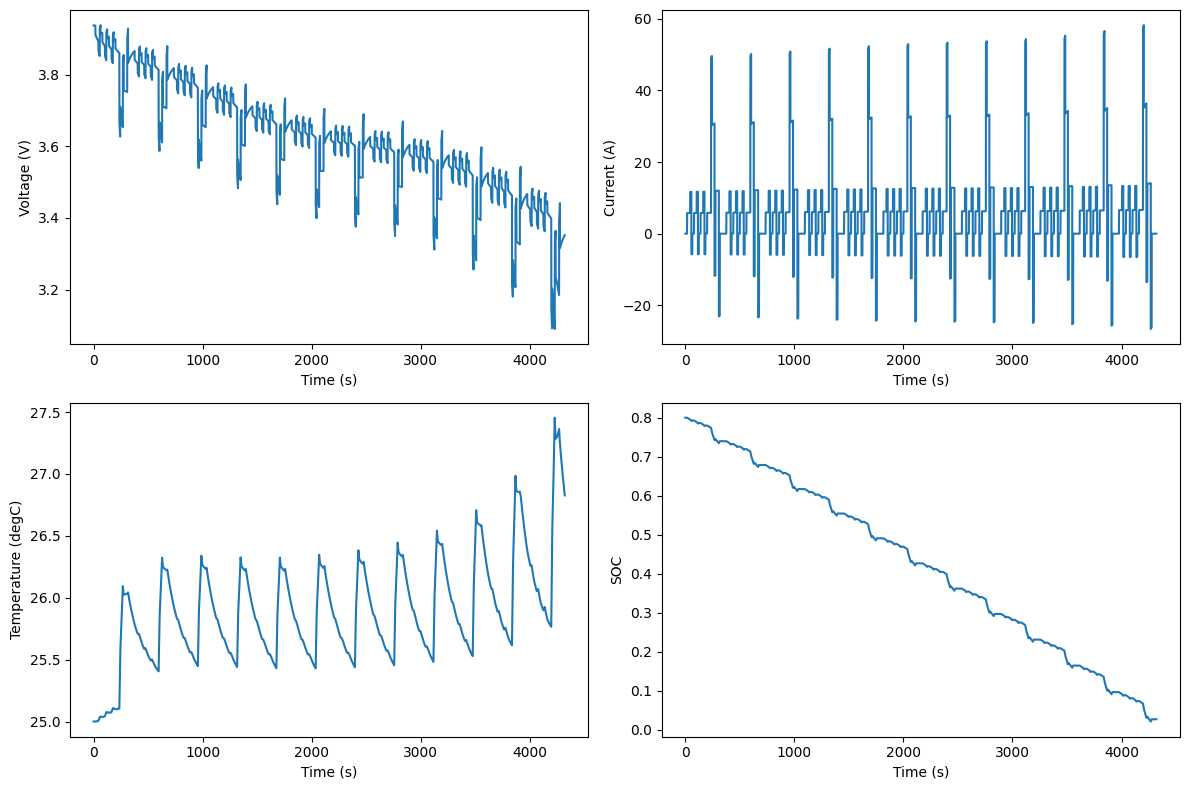

In [2]:
battery = Thevenin(default_thevenin_inputs)

dt = 1.0
solution = battery.solve(protocol.dst_schedule(peak_power=180, number_of_cycles=12, sampling_time_s=dt))

time = solution.time
voltage = solution.voltage
current = solution.current
soc = solution.soc
cell_temperature = solution.cell_temperature

quick_plot(
    time=[time],
    data=[voltage, current, cell_temperature, soc],
    legends=["voltage", "current", "temperature", "soc"],
    x_labels="Time (s)",
    y_labels=["Voltage (V)", "Current (A)", "Temperature (degC)", "SOC"],
)

## State Estimator

We here set up the dynamic system and corresponding EKF observer. The design choices are
1. Isothermal and 1-RC Thevenin model
2. Time-invariant model parameters and state transition matrices ($\mathbf{F}$ and $\mathbf{B}$)
3. Constant process and measurement noise covariance matrices ($\mathbf{Q}$ and $\mathbf{R}$)

In [3]:
system = IsothermalThevenin(
    ocv_func=default_thevenin_inputs.open_circuit_voltage,
    series_resistance=4e-3,  # true value: soc-dependent
    rc_resistors=[7e-3],  # true value: soc-dependent
    rc_capacitors=[8e3],  # true value: soc-dependent
    capacity=10,  # real value: 10
)

ekf = ExtendedKalmanFilter(
    F=system.F(dt),  # state transition matrix
    B=system.B(dt),  # input matrix
    Q=np.diag([0.01**2, 0.1**2]),  # process noise
    R=1e-5,  # measurement noise
    x0=np.array([0.75, 0.0]),  # initial states [soc, v_rc1]
    P0=np.diag([1e-5, 1]),  # initial covariance of states
)

## Sensors

Each state estimator requires sensor readings as inputs. Here we set up the sensors to read the voltage and current data generated above. For simplicity, we assume that the sensors are perfect without faults or noise. We will study the effect of sensor noise on state estimation in a future tutorial.

In [4]:
voltage_sensor = Sensor(name="voltage", time=time, data=voltage)
current_sensor = Sensor(name="current", time=time, data=current)

## Run Estimation

We are now ready to run the state estimation. We first reset the sensors and the state estimator. Then we loop through the data and update the state estimator with the sensor readings. The state estimator returns the estimated SOC and the covariance of the SOC estimate. We store the SOC estimate and the SOC estimate covariance for later use.

In [5]:
v_sense = []
curr_sense = []
soc_ekf, soc_ekf_std, vrc_ekf_std = [], [], []

voltage_sensor.reset()
current_sensor.reset()
ekf.reset()

try:
    while True:
        # sensor readings
        voltage_reading = voltage_sensor.read()
        current_reading = current_sensor.read()

        # extended kalman filter
        ekf.predict(u=current_reading)
        ekf.update(
            z=voltage_reading,
            hx=system.hx,
            hx_args=current_reading,
            h_jacobian=system.h_jacobian,
        )

        # store states and sensor readings
        soc_ekf.append(ekf.x[0, 0])
        soc_ekf_std.append(np.sqrt(ekf.P[0, 0]))
        vrc_ekf_std.append(np.sqrt(ekf.P[1, 1]))

        v_sense.append(voltage_reading)
        curr_sense.append(current_reading)

except IndexError as e:
    print(e)

Sensor 'voltage' finished reading.


## Plot Results

We now use `quick_plot` to plot the results. The true and (fault-less and noise-less) sensor readings, estimated states and statistics are plotted.

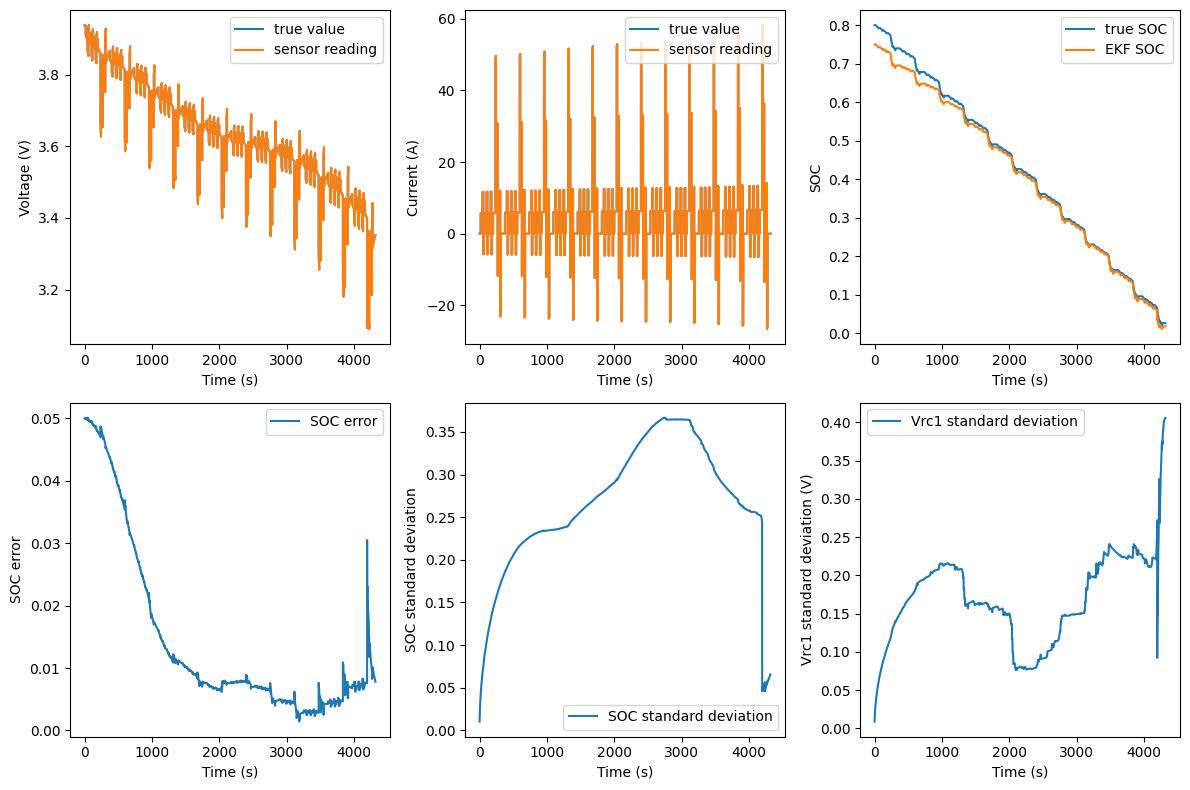

In [6]:
quick_plot(
    time=[time],
    data=[[voltage, v_sense], [current, curr_sense], [soc, soc_ekf], [soc - soc_ekf], [soc_ekf_std], [vrc_ekf_std]],
    legends=[
        ["true value", "sensor reading"],
        ["true value", "sensor reading"],
        ["true SOC", "EKF SOC"],
        ["SOC error"],
        ["SOC standard deviation"],
        ["Vrc1 standard deviation"],
    ],
    x_labels="Time (s)",
    y_labels=[
        "Voltage (V)",
        "Current (A)",
        "SOC",
        "SOC error",
        "SOC standard deviation",
        "Vrc1 standard deviation (V)",
    ],
    n_cols=3,
)

We see that EKF (even with isothermal and time-invariant model parameters) does a decent job estimating SOC, but there are a number of issues with our setup that can be improved: the SOC convergence is slow (around 30 min), state estimation confidence is low (note SOC and Vc1 standard deviations of around 0.3 and 0.2V, respectively), and deterioration of state estimate at low SOC regions (around 0.1 and below).

These will be a topic of discussion in future tutorials, where we will explore how to improve the state estimation performance by tuning the EKF parameters and using more sophisticated models.